In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.tsa.stattools import acf

from scipy import stats

from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [3]:
class Markov:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.model = LinearRegression()
        self.model.fit(X, y)
        self.predictions = self.model.predict(X)
        self.errors = self.y - self.predictions
        self.X_const = sm.add_constant(X)
        self.lm_results = sm.OLS(y, self.X_const).fit()
        self.coefs = self.model.coef_
        self.intercepts = self.model.intercept_

    def plot_linearity(self):
        count = 1
        plt.figure(figsize=(25, 15))
        cols = self.X.columns
        for col in self.X.columns:
            plt.subplot(5, 5, count)
            plt.scatter(self.X[col], self.predictions)
            plt.xlabel(col)
            plt.ylabel("target")
            count += 1

        plt.tight_layout()
        plt.show()

    def plot_homoscedasticity(self):
        plt.scatter(self.predictions, self.errors)
        plt.xlabel("Predicted")
        plt.ylabel("Residual")
        plt.axhline(y=0)
        plt.title("Residual vs. Predicted")
        plt.show()

    def b_pagan(self):
        _, lmp, _, fp = het_breuschpagan(lm_results.resid, X)

        return lmp, fp

    def get_vifs(self):
        vifs = []
        for i in range(self.X_const.shape[1]):
            vif = variance_inflation_factor(self.X_const.values, i)
            vifs.append(vif)

        return pd.Series(vifs, index=self.X_const.columns)

    def plot_errors(self):
        plt.plot(self.errors)
        plt.show()

    def plot_errors_acf(self):
        acf_data = acf(self.errors)

        plt.plot(acf_data[1:])
        plt.show()

    def plot_error_normality(self):
        qqplot(lm_results.resid, line="s")
        plt.show()

        plt.hist(lm_results.resid)
        plt.show()

    def shapiro_wilkes(self):
        return stats.shapiro(self.lm_results.resid)

<IPython.core.display.Javascript object>

## Load the data

In [4]:
warnings.filterwarnings("ignore")

postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)
house_prices_df = pd.read_sql_query("select * from houseprices", con=engine)

engine.dispose()

house_prices_df

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2010,WD,Normal,142125


<IPython.core.display.Javascript object>

## Data cleaning, analysis, feature engineering

In [5]:
house_prices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


<IPython.core.display.Javascript object>

In [6]:
# Use ID as index
house_prices_df = house_prices_df.set_index("id")
house_prices_df.shape

(1460, 80)

<IPython.core.display.Javascript object>

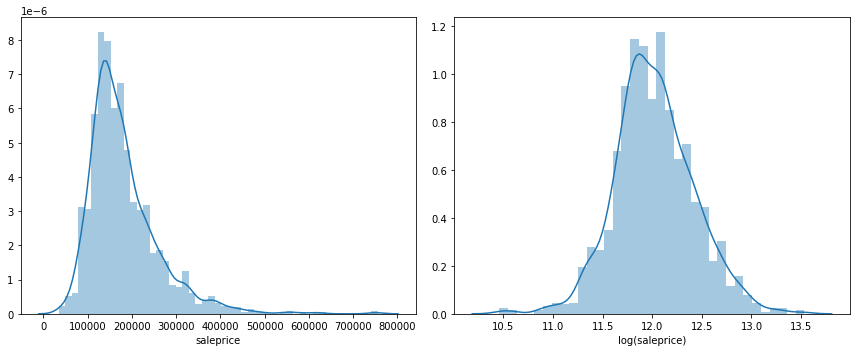

<IPython.core.display.Javascript object>

In [7]:
# Target variable is not normal, log transform is normal
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.distplot(house_prices_df["saleprice"], ax=axes[0])

sns.distplot(np.log(house_prices_df["saleprice"]), ax=axes[1])
axes[1].set_xlabel("log(saleprice)")

plt.tight_layout()
plt.show()

In [8]:
# Create log_saleprice column
log_df = house_prices_df.copy()
log_df["log_saleprice"] = np.log(log_df["saleprice"])
log_df = log_df.drop(columns=["saleprice"])

<IPython.core.display.Javascript object>

In [9]:
# Get top ten correlated variables
corr_df = log_df.corr()[["log_saleprice"]]
corr_df.columns = ["corr"]
corr_df["abs_corr"] = corr_df.abs()
top_corrs = corr_df.sort_values("abs_corr", ascending=False).head(10)
top_corrs

,corr,abs_corr
log_saleprice,1.000000,1.000000
overallqual,0.817184,0.817184
grlivarea,0.700927,0.700927
garagecars,0.680625,0.680625
garagearea,0.650888,0.650888
totalbsmtsf,0.612134,0.612134
firstflrsf,0.596981,0.596981
fullbath,0.594771,0.594771
yearbuilt,0.586570,0.586570
yearremodadd,0.565608,0.565608


<IPython.core.display.Javascript object>

Plot top_corrs

In [10]:
def plot_top_corrs(df, column, top_corrs_df, n=10):
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()

<IPython.core.display.Javascript object>

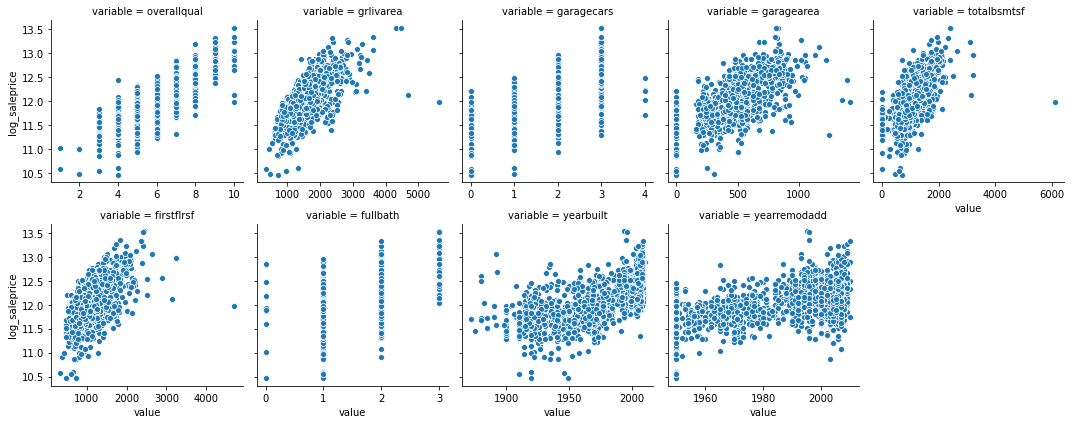

<IPython.core.display.Javascript object>

In [11]:
plot_top_corrs(log_df, "log_saleprice", top_corrs)

There are a few houses that sold for very low despite their features. Lets drop the 4 most expensive houses.

In [12]:
# Drop the 5 most expensive houses
drop_ids = log_df.sort_values("firstflrsf", ascending=False).iloc[:5].index
log_df = log_df.drop(index=drop_ids)

<IPython.core.display.Javascript object>

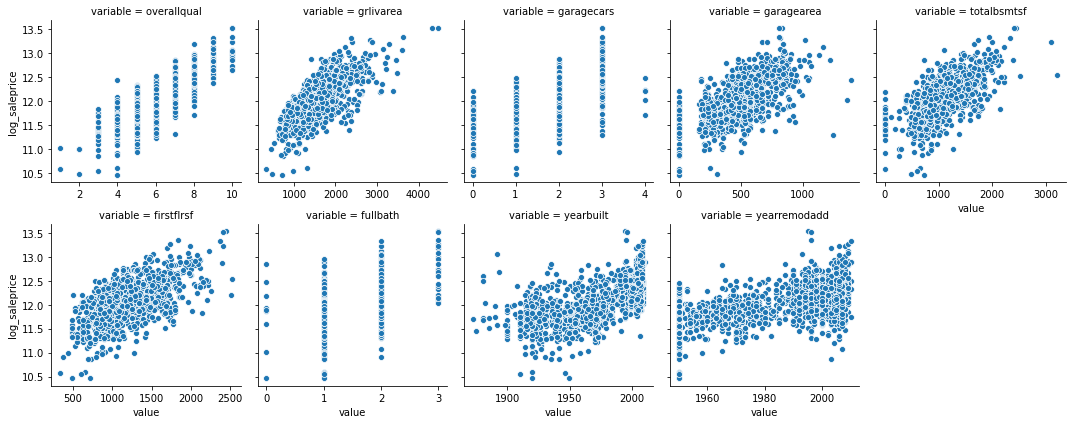

<IPython.core.display.Javascript object>

In [13]:
# Replot top correlated variables
plot_top_corrs(log_df, "log_saleprice", top_corrs)

In [14]:
# Keep only top correlated columns
num_cols = log_df.select_dtypes("number").columns
keep_cols = top_corrs.index
drop_cols = [c for c in num_cols if c not in keep_cols]
log_df = log_df.drop(columns=drop_cols)
log_df

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagearea,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition,log_saleprice
id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,548,TA,TA,Y,None,None,None,WD,Normal,12.247694
2,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,460,TA,TA,Y,None,None,None,WD,Normal,12.109011
3,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,608,TA,TA,Y,None,None,None,WD,Normal,12.317167
4,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,642,TA,TA,Y,None,None,None,WD,Abnorml,11.849398
5,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,836,TA,TA,Y,None,None,None,WD,Normal,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,460,TA,TA,Y,None,None,None,WD,Normal,12.072541
1457,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,500,TA,TA,Y,None,MnPrv,None,WD,Normal,12.254863
1458,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,252,TA,TA,Y,None,GdPrv,Shed,WD,Normal,12.493130


<IPython.core.display.Javascript object>

In [15]:
# Check for nulls
house_prices_df.isna().mean().sort_values(ascending=False).head(10)

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagetype      0.055479
garagecond      0.055479
garagefinish    0.055479
garagequal      0.055479
dtype: float64

<IPython.core.display.Javascript object>

We've already narrowed our list of features down to 9. The columns with a lot of nulls are not in our features. We will drop these columns.

In [16]:
# Drop top 5 columns with null values, drop remaining rows with nulls
drop_cols = ["poolqc", "alley", "fence", "fireplacequ", "miscfeature"]
log_df = log_df.drop(columns=drop_cols)
log_df = log_df.dropna()

print(log_df.shape)
log_df.head()

(1333, 48)


,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,garagetype,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,saletype,salecondition,log_saleprice
id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Attchd,RFn,2,548,TA,TA,Y,WD,Normal,12.247694
2,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,Attchd,RFn,2,460,TA,TA,Y,WD,Normal,12.109011
3,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Attchd,RFn,2,608,TA,TA,Y,WD,Normal,12.317167
4,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Detchd,Unf,3,642,TA,TA,Y,WD,Abnorml,11.849398
5,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Attchd,RFn,3,836,TA,TA,Y,WD,Normal,12.429216


<IPython.core.display.Javascript object>

In [17]:
# Analyze categorical variables
cat_cols = log_df.select_dtypes("O").copy()
anova_results = []
for col in cat_cols:
    groups = list(log_df[["log_saleprice", col]].groupby(col))
    samples = [group[1]["log_saleprice"] for group in groups]
    f, p = stats.f_oneway(*samples)

    anova_result = {"col": col, "f": f, "p": p}
    anova_results.append(anova_result)

anova_results_df = pd.DataFrame(anova_results).sort_values("f", ascending=False)
top_f = anova_results_df.head(10)
top_f

,col,f,p
17,exterqual,373.767448,5.501240e-176
20,bsmtqual,364.681465,9.244823e-173
29,kitchenqual,354.541228,4.060917e-169
32,garagefinish,309.531402,4.238010e-111
19,foundation,134.245625,2.286649e-96
27,centralair,112.636026,2.577985e-25
26,heatingqc,98.515474,1.785170e-73
16,masvnrtype,97.714055,3.734057e-57
31,garagetype,93.257407,2.909729e-84
0,mszoning,71.624582,5.514147e-55


<IPython.core.display.Javascript object>

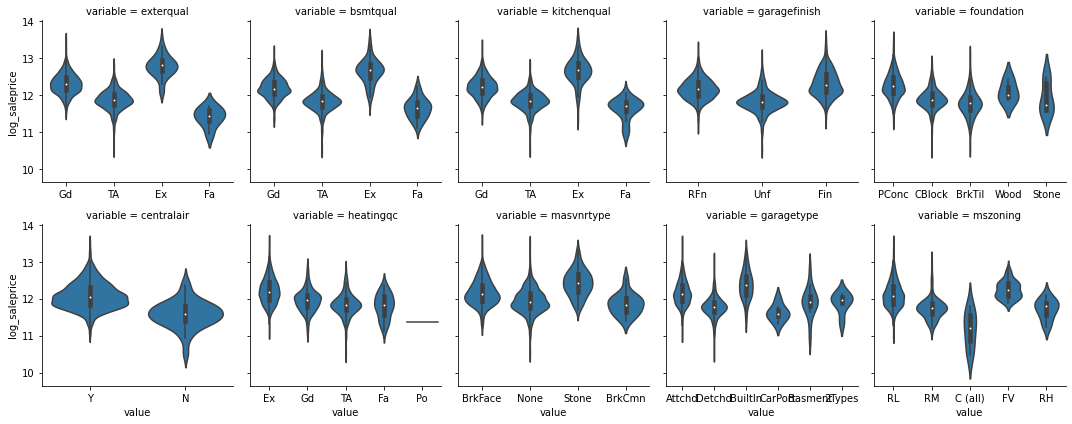

<IPython.core.display.Javascript object>

In [18]:
cat_cols = log_df.select_dtypes("O").copy()[top_f["col"]]
cat_cols["log_saleprice"] = log_df["log_saleprice"]

tall_cat_cols = pd.melt(cat_cols, "log_saleprice")

fg = sns.FacetGrid(tall_cat_cols, col="variable", col_wrap=5, sharex=False)
fg.map(sns.violinplot, "value", "log_saleprice")
plt.show()

The variables with the highest f-test scores are `exterqual, bsmtqual, kitchenqual, garagefinish`. These variables also look like they have a significant difference of means between their categories.

In [19]:
# Drop category columns except for exterqual, bsmtqual, kitchenqual, garagefinish
cat_cols = log_df.select_dtypes("O").copy()
keep_cols = ["exterqual", "bsmtqual", "kitchenqual", "garagefinish"]
drop_cols = [c for c in cat_cols.columns if c not in keep_cols]
log_df = log_df.drop(columns=drop_cols)

<IPython.core.display.Javascript object>

In [20]:
# Encode qual columns as ordinal
quality_map = {"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
log_df[["exterqual", "bsmtqual", "kitchenqual"]] = log_df[
    ["exterqual", "bsmtqual", "kitchenqual"]
].replace(quality_map)

<IPython.core.display.Javascript object>

In [21]:
def one_hot_encode(X, encode_cols, index=None):
    other_cols = [c for c in X.columns if c not in encode_cols]

    ct = ColumnTransformer(
        #   Format
        #   [("name of step", what_to_do(), [what columns to do it to])]
        [("one hot encode", OneHotEncoder(drop="first", sparse=False), encode_cols)],
        remainder="passthrough",
    )

    ct.fit(X)

    encoded_names = ct.transformers_[0][1].get_feature_names()
    encoded_names = list(encoded_names)

    X_encoded = ct.transform(X)
    X_encoded = pd.DataFrame(X_encoded, columns=encoded_names + other_cols, index=index)

    return X_encoded

<IPython.core.display.Javascript object>

In [22]:
# one hot encode garagefinish
log_df = one_hot_encode(log_df, encode_cols=["garagefinish"], index=log_df.index)

<IPython.core.display.Javascript object>

In [23]:
print(log_df.shape)
log_df.head()

(1333, 15)


,x0_RFn,x0_Unf,overallqual,yearbuilt,yearremodadd,exterqual,bsmtqual,totalbsmtsf,firstflrsf,grlivarea,fullbath,kitchenqual,garagecars,garagearea,log_saleprice
id,,,,,,,,,,,,,,,
1,1.0,0.0,7.0,2003.0,2003.0,3.0,3.0,856.0,856.0,1710.0,2.0,3.0,2.0,548.0,12.247694
2,1.0,0.0,6.0,1976.0,1976.0,2.0,3.0,1262.0,1262.0,1262.0,2.0,2.0,2.0,460.0,12.109011
3,1.0,0.0,7.0,2001.0,2002.0,3.0,3.0,920.0,920.0,1786.0,2.0,3.0,2.0,608.0,12.317167
4,0.0,1.0,7.0,1915.0,1970.0,2.0,2.0,756.0,961.0,1717.0,1.0,3.0,3.0,642.0,11.849398
5,1.0,0.0,8.0,2000.0,2000.0,3.0,3.0,1145.0,1145.0,2198.0,2.0,3.0,3.0,836.0,12.429216


<IPython.core.display.Javascript object>

In [24]:
X = log_df.drop(columns=["log_saleprice"])
y = log_df["log_saleprice"]
house_markov = Markov(X, y)

<IPython.core.display.Javascript object>

In [25]:
lm_results = house_markov.lm_results
lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     552.6
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:14:46   Log-Likelihood:                 699.16
No. Observations:                1333   AIC:                            -1368.
Df Residuals:                    1318   BIC:                            -1290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.4459      0.646      6.881      0.000       3.178       5.713
x0_RFn          -0.0119      0.011     -1.091      0.275      -0.033       0.010
x0_Unf          -0.0515      0.013     -4.049      0.000      -0.076      -0.027
overallqual      0.0711      0.005     13.055      0.000       0.060       0.082
yearbuilt        0.0014      0.000      5.810      0.000       0.001       0.002
yearremodadd     0.0018      0.000      6.101      0.000       0.001       0.002
exterqual        0.0066      0.012      0.564      0.573      -0.016       0.030
bsmtqual         0.0287      0.010      2.936      0.003       0.010       0.048
totalbsmtsf      0.0001   2.59e-05      5.739      0.000    9.78e-05       0.000
firstflrsf    4.801e-05   2.64e-05      1.820      0.069   -3.74e-06    9.98e-05
grlivarea        0.0003    1.3e-05     22.726      0.000       0.000       0.000
fullbath        -0.0473      0.011     -4.325      0.000      -0.069      -0.026
kitchenqual      0.0398      0.010      4.104      0.000       0.021       0.059
garagecars       0.0109      0.013      0.854      0.393      -0.014       0.036
garagearea       0.0001   4.08e-05      2.791      0.005    3.38e-05       0.000
==============================================================================
Omnibus:                      285.557   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1255.892
Skew:                          -0.948   Prob(JB):                    1.93e-273
Kurtosis:                       7.361   Cond. No.                     5.94e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

Some of are variables are not significant in predicting saleprice. We'll remove `x0_RFn, exterqual, firstflrsf, and garagecars`

In [26]:
log_df = log_df.drop(columns=["garagecars", "firstflrsf", "exterqual", "x0_RFn"])

<IPython.core.display.Javascript object>

In [27]:
# cols_to_log = list(log_df.columns)
# cols_to_log.remove("log_saleprice")
# print(cols_to_log)

<IPython.core.display.Javascript object>

In [28]:
# for col in cols_to_log:
#     log_df["log_" + col] = np.log(log_df[col])
#     log_df = log_df.drop(columns=[col])

<IPython.core.display.Javascript object>

In [29]:
X = log_df.drop(columns=["log_saleprice"])
y = log_df["log_saleprice"]

<IPython.core.display.Javascript object>

In [30]:
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
house_markov = Markov(X_train, y_train)

<IPython.core.display.Javascript object>

In [31]:
lm_results = house_markov.lm_results
lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     611.7
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:14:47   Log-Likelihood:                 537.87
No. Observations:                1066   AIC:                            -1054.
Df Residuals:                    1055   BIC:                            -999.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.8118      0.717      6.710      0.000       3.405       6.219
x0_Unf          -0.0489      0.012     -4.067      0.000      -0.072      -0.025
overallqual      0.0706      0.006     11.721      0.000       0.059       0.082
yearbuilt        0.0013      0.000      4.746      0.000       0.001       0.002
yearremodadd     0.0017      0.000      5.243      0.000       0.001       0.002
bsmtqual         0.0326      0.011      2.972      0.003       0.011       0.054
totalbsmtsf      0.0002   1.53e-05     12.227      0.000       0.000       0.000
grlivarea        0.0003   1.39e-05     21.687      0.000       0.000       0.000
fullbath        -0.0446      0.012     -3.602      0.000      -0.069      -0.020
kitchenqual      0.0456      0.010      4.398      0.000       0.025       0.066
garagearea       0.0002   3.13e-05      4.823      0.000    8.94e-05       0.000
==============================================================================
Omnibus:                      247.946   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1228.514
Skew:                          -0.985   Prob(JB):                    1.70e-267
Kurtosis:                       7.876   Cond. No.                     5.47e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

In [32]:
y_pred = lm_results.predict(X_test)
y_pred_exp = np.exp(y_pred)
y_pred_exp

id
1063    147709.914414
405     166795.650263
790     196813.263653
1117    185943.541640
782     175785.372227
            ...      
836     123740.889057
1357    116528.638192
9       155518.129979
267     165327.331305
1419    126415.801433
Length: 267, dtype: float64

<IPython.core.display.Javascript object>

In [33]:
y_test_exp = np.exp(y_test)
y_test_exp

id
1063     90000.0
405     168000.0
790     187500.0
1117    184100.0
782     175900.0
          ...   
836     128000.0
1357    110000.0
9       129900.0
267     185000.0
1419    124000.0
Name: log_saleprice, Length: 267, dtype: float64

<IPython.core.display.Javascript object>

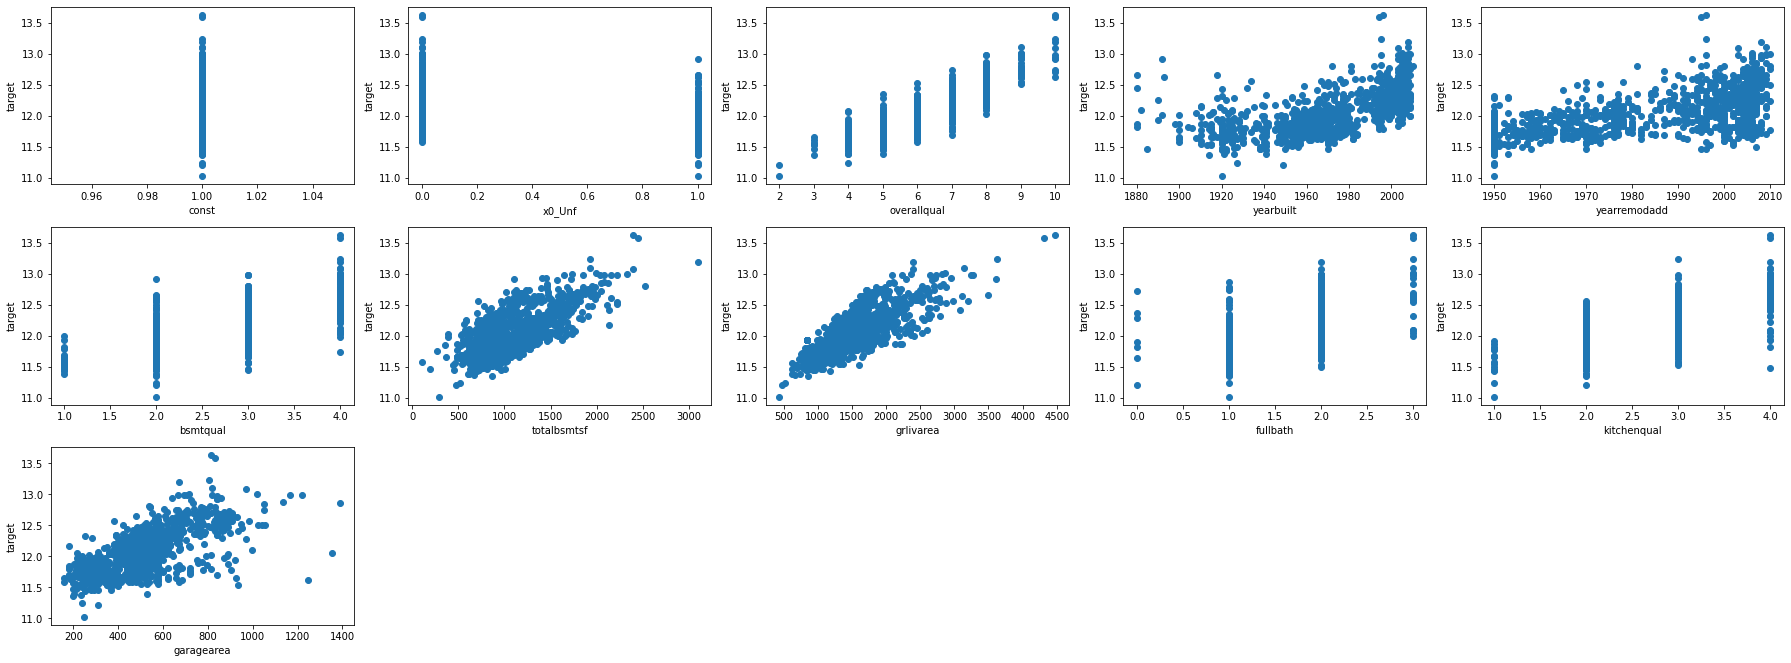

<IPython.core.display.Javascript object>

In [34]:
house_markov.plot_linearity()

Features appear linear.

In [35]:
# Test for mean of errors
errors = y_test - y_pred
print("Mean of the errors in the medical costs model is:", np.mean(errors))

Mean of the errors in the medical costs model is: 0.0020459464138257526


<IPython.core.display.Javascript object>

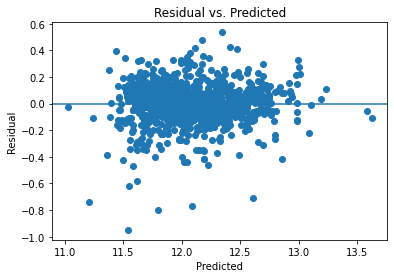

<IPython.core.display.Javascript object>

In [36]:
house_markov.plot_homoscedasticity()

In [37]:
_, lmp, _, fp = het_breuschpagan(lm_results.resid, X_train)
print(lmp)
print(fp)

1.1098663970199703e-05
8.919350619033746e-06


<IPython.core.display.Javascript object>

Errors are not homoscedastic.

In [38]:
house_markov.get_vifs()

const           25421.195250
x0_Unf              1.743258
overallqual         3.155484
yearbuilt           3.201773
yearremodadd        2.188412
bsmtqual            2.758736
totalbsmtsf         1.633256
grlivarea           2.470746
fullbath            2.247083
kitchenqual         2.288461
garagearea          1.695139
dtype: float64

<IPython.core.display.Javascript object>

Low multicollinearity

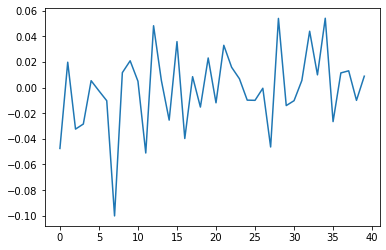

<IPython.core.display.Javascript object>

In [39]:
# Plot autocorrelation of errors
house_markov.plot_errors_acf()

Autocorrelation is low (ranging between -0.20 and 0.10

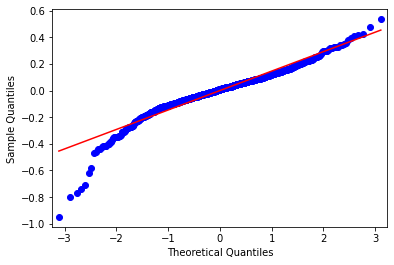

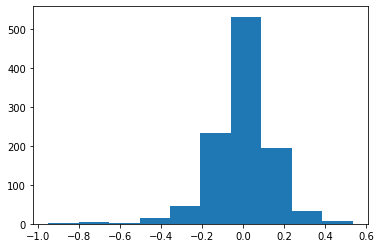

<IPython.core.display.Javascript object>

In [40]:
# Histogram and qqplot of errors
house_markov.plot_error_normality()

In [41]:
stats.shapiro(lm_results.resid)

(0.9390204548835754, 1.692727542126884e-20)

<IPython.core.display.Javascript object>

Errors are not normally distributed.

## Model Testing

In [42]:
# OlS regression
lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     611.7
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:15:03   Log-Likelihood:                 537.87
No. Observations:                1066   AIC:                            -1054.
Df Residuals:                    1055   BIC:                            -999.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.8118      0.717      6.710      0.000       3.405       6.219
x0_Unf          -0.0489      0.012     -4.067      0.000      -0.072      -0.025
overallqual      0.0706      0.006     11.721      0.000       0.059       0.082
yearbuilt        0.0013      0.000      4.746      0.000       0.001       0.002
yearremodadd     0.0017      0.000      5.243      0.000       0.001       0.002
bsmtqual         0.0326      0.011      2.972      0.003       0.011       0.054
totalbsmtsf      0.0002   1.53e-05     12.227      0.000       0.000       0.000
grlivarea        0.0003   1.39e-05     21.687      0.000       0.000       0.000
fullbath        -0.0446      0.012     -3.602      0.000      -0.069      -0.020
kitchenqual      0.0456      0.010      4.398      0.000       0.025       0.066
garagearea       0.0002   3.13e-05      4.823      0.000    8.94e-05       0.000
==============================================================================
Omnibus:                      247.946   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1228.514
Skew:                          -0.985   Prob(JB):                    1.70e-267
Kurtosis:                       7.876   Cond. No.                     5.47e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

In [43]:
evaluators = [
    "Mean Absolute Error",
    "Mean Squared Error",
    "Root Mean Square Error",
    "Mean Absolute Percentage Error",
]
evaluations = [
    mean_absolute_error(y_test_exp, y_pred_exp),
    mse(y_test_exp, y_pred_exp),
    rmse(y_test_exp, y_pred_exp),
    np.mean(np.abs((y_test_exp - y_pred_exp) / y_test_exp)) * 100,
]
evaluation_df = pd.DataFrame({"Evaluator": evaluators, "Error": evaluations})
evaluation_df

,Evaluator,Error
0,Mean Absolute Error,1.721693e+04
1,Mean Squared Error,5.115851e+08
2,Root Mean Square Error,2.261825e+04
3,Mean Absolute Percentage Error,1.033312e+01


<IPython.core.display.Javascript object>

In [44]:
alphas = [np.power(10.0, p) for p in np.arange(-10, 40, 1)]

<IPython.core.display.Javascript object>

In [45]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

y_preds_test = lasso_cv.predict(X_test)

print("Alpha:", lasso_cv.alpha_, "\n")
print("R-squared train set:", lasso_cv.score(X_train, y_train))
print("R-squared test set:", lasso_cv.score(X_test, y_test))

evaluations = [
    mean_absolute_error(y_test_exp, y_pred_exp),
    mse(y_test_exp, y_pred_exp),
    rmse(y_test_exp, y_pred_exp),
    np.mean(np.abs((y_test_exp - y_pred_exp) / y_test_exp)) * 100,
]
evaluation_df = pd.DataFrame({"Evaluator": evaluators, "Error": evaluations})
evaluation_df

Alpha: 0.0001 

R-squared train set: 0.8528975218940853
R-squared test set: 0.8562327492454032


,Evaluator,Error
0,Mean Absolute Error,1.721693e+04
1,Mean Squared Error,5.115851e+08
2,Root Mean Square Error,2.261825e+04
3,Mean Absolute Percentage Error,1.033312e+01


<IPython.core.display.Javascript object>

In [46]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

y_preds_test = ridge_cv.predict(X_test)

y_pred_exp = np.exp(y_preds_test)

print("Alpha:", ridge_cv.alpha_, "\n")
print("R-squared train set:", ridge_cv.score(X_train, y_train))
print("R-squared test set:", ridge_cv.score(X_test, y_test))

evaluations = [
    mean_absolute_error(y_test_exp, y_pred_exp),
    mse(y_test_exp, y_pred_exp),
    rmse(y_test_exp, y_pred_exp),
    np.mean(np.abs((y_test_exp - y_pred_exp) / y_test_exp)) * 100,
]
evaluation_df = pd.DataFrame({"Evaluator": evaluators, "Error": evaluations})
evaluation_df

Alpha: 10.0 

R-squared train set: 0.8528726876681848
R-squared test set: 0.8563151028919632


,Evaluator,Error
0,Mean Absolute Error,1.719142e+04
1,Mean Squared Error,5.109696e+08
2,Root Mean Square Error,2.260464e+04
3,Mean Absolute Percentage Error,1.031778e+01


<IPython.core.display.Javascript object>

In [47]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

y_preds_test = elasticnet_cv.predict(X_test)

y_pred_exp = np.exp(y_preds_test)

print("Alpha:", elasticnet_cv.alpha_, "\n")
print("R-squared train set:", elasticnet_cv.score(X_train, y_train))
print("R-squared test set:", elasticnet_cv.score(X_test, y_test))

evaluations = [
    mean_absolute_error(y_test_exp, y_pred_exp),
    mse(y_test_exp, y_pred_exp),
    rmse(y_test_exp, y_pred_exp),
    np.mean(np.abs((y_test_exp - y_pred_exp) / y_test_exp)) * 100,
]
evaluation_df = pd.DataFrame({"Evaluator": evaluators, "Error": evaluations})
evaluation_df

Alpha: 0.0001 

R-squared train set: 0.852898730454904
R-squared test set: 0.85621025370867


,Evaluator,Error
0,Mean Absolute Error,1.721446e+04
1,Mean Squared Error,5.114511e+08
2,Root Mean Square Error,2.261528e+04
3,Mean Absolute Percentage Error,1.033165e+01


<IPython.core.display.Javascript object>

##### Results

Performing cross validations does not appear to greatly approve the accuracy of our model. Our model can predict the sale price of houses with a mean absolute error of $17,214.46 or 10 percent of the sale price.

### Additional Data

##### Housing Starts by month from 1959 to 2020
* https://fred.stlouisfed.org/series/HOUSTNSA
* Number of privately owned housing units started by month

In [48]:
housing_starts = pd.read_csv("HOUST.csv")
housing_starts

,DATE,HOUST
0,1959-01-01,1657.0
1,1959-02-01,1667.0
2,1959-03-01,1620.0
3,1959-04-01,1590.0
4,1959-05-01,1498.0
...,...,...
729,2019-10-01,1340.0
730,2019-11-01,1381.0
731,2019-12-01,1601.0
732,2020-01-01,1624.0


<IPython.core.display.Javascript object>

In [49]:
# Create series of average housing starts per month by year
housing_starts["DATE"] = pd.to_datetime(housing_starts["DATE"])
avg_starts = housing_starts.groupby(housing_starts["DATE"].dt.year)["HOUST"].mean()
avg_starts

DATE
1959    1535.333333
1960    1256.000000
1961    1311.500000
1962    1458.583333
1963    1588.333333
           ...     
2016    1177.916667
2017    1208.750000
2018    1249.583333
2019    1297.750000
2020    1611.500000
Name: HOUST, Length: 62, dtype: float64

<IPython.core.display.Javascript object>

In [59]:
avg_starts_dict = avg_starts.to_dict()

<IPython.core.display.Javascript object>

In [60]:
avg_starts_dict

{1959: 1535.3333333333333,
 1960: 1256.0,
 1961: 1311.5,
 1962: 1458.5833333333333,
 1963: 1588.3333333333333,
 1964: 1540.4166666666667,
 1965: 1469.3333333333333,
 1966: 1166.5,
 1967: 1284.8333333333333,
 1968: 1503.5833333333333,
 1969: 1486.6666666666667,
 1970: 1434.8333333333333,
 1971: 2035.5833333333333,
 1972: 2360.75,
 1973: 2043.9166666666667,
 1974: 1331.9166666666667,
 1975: 1159.75,
 1976: 1535.0,
 1977: 1961.8333333333333,
 1978: 2000.5833333333333,
 1979: 1717.25,
 1980: 1300.25,
 1981: 1096.3333333333333,
 1982: 1057.3333333333333,
 1983: 1705.4166666666667,
 1984: 1766.25,
 1985: 1741.4166666666667,
 1986: 1811.9166666666667,
 1987: 1630.5,
 1988: 1487.8333333333333,
 1989: 1382.0833333333333,
 1990: 1203.1666666666667,
 1991: 1008.75,
 1992: 1201.4166666666667,
 1993: 1291.5833333333333,
 1994: 1446.0,
 1995: 1361.0,
 1996: 1468.6666666666667,
 1997: 1474.5833333333333,
 1998: 1621.1666666666667,
 1999: 1647.25,
 2000: 1573.3333333333333,
 2001: 1601.1666666666667,


<IPython.core.display.Javascript object>

In [54]:
log_df_starts = log_df.copy()

<IPython.core.display.Javascript object>

In [55]:
log_df_starts = log_df.join(house_prices_df["yrsold"])
log_df_starts

,x0_Unf,overallqual,yearbuilt,yearremodadd,bsmtqual,totalbsmtsf,grlivarea,fullbath,kitchenqual,garagearea,log_saleprice,yrsold
id,,,,,,,,,,,,
1,0.0,7.0,2003.0,2003.0,3.0,856.0,1710.0,2.0,3.0,548.0,12.247694,2008
2,0.0,6.0,1976.0,1976.0,3.0,1262.0,1262.0,2.0,2.0,460.0,12.109011,2007
3,0.0,7.0,2001.0,2002.0,3.0,920.0,1786.0,2.0,3.0,608.0,12.317167,2008
4,1.0,7.0,1915.0,1970.0,2.0,756.0,1717.0,1.0,3.0,642.0,11.849398,2006
5,0.0,8.0,2000.0,2000.0,3.0,1145.0,2198.0,2.0,3.0,836.0,12.429216,2008
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.0,6.0,1999.0,2000.0,3.0,953.0,1647.0,2.0,2.0,460.0,12.072541,2007
1457,1.0,6.0,1978.0,1988.0,3.0,1542.0,2073.0,2.0,2.0,500.0,12.254863,2010
1458,0.0,7.0,1941.0,2006.0,2.0,1152.0,2340.0,2.0,3.0,252.0,12.493130,2010


<IPython.core.display.Javascript object>

In [57]:
log_df_starts["yrsold_copy"] = log_df_starts["yrsold"]

<IPython.core.display.Javascript object>

In [61]:
log_df_starts

,x0_Unf,overallqual,yearbuilt,yearremodadd,bsmtqual,totalbsmtsf,grlivarea,fullbath,kitchenqual,garagearea,log_saleprice,yrsold,yrsold_copy
id,,,,,,,,,,,,,
1,0.0,7.0,2003.0,2003.0,3.0,856.0,1710.0,2.0,3.0,548.0,12.247694,2008,2008
2,0.0,6.0,1976.0,1976.0,3.0,1262.0,1262.0,2.0,2.0,460.0,12.109011,2007,2007
3,0.0,7.0,2001.0,2002.0,3.0,920.0,1786.0,2.0,3.0,608.0,12.317167,2008,2008
4,1.0,7.0,1915.0,1970.0,2.0,756.0,1717.0,1.0,3.0,642.0,11.849398,2006,2006
5,0.0,8.0,2000.0,2000.0,3.0,1145.0,2198.0,2.0,3.0,836.0,12.429216,2008,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.0,6.0,1999.0,2000.0,3.0,953.0,1647.0,2.0,2.0,460.0,12.072541,2007,2007
1457,1.0,6.0,1978.0,1988.0,3.0,1542.0,2073.0,2.0,2.0,500.0,12.254863,2010,2010
1458,0.0,7.0,1941.0,2006.0,2.0,1152.0,2340.0,2.0,3.0,252.0,12.493130,2010,2010


<IPython.core.display.Javascript object>

In [62]:
log_df_starts.replace({"yrsold_copy": avg_starts_dict}, inplace=True)
log_df_starts

,x0_Unf,overallqual,yearbuilt,yearremodadd,bsmtqual,totalbsmtsf,grlivarea,fullbath,kitchenqual,garagearea,log_saleprice,yrsold,yrsold_copy
id,,,,,,,,,,,,,
1,0.0,7.0,2003.0,2003.0,3.0,856.0,1710.0,2.0,3.0,548.0,12.247694,2008,900.000000
2,0.0,6.0,1976.0,1976.0,3.0,1262.0,1262.0,2.0,2.0,460.0,12.109011,2007,1341.833333
3,0.0,7.0,2001.0,2002.0,3.0,920.0,1786.0,2.0,3.0,608.0,12.317167,2008,900.000000
4,1.0,7.0,1915.0,1970.0,2.0,756.0,1717.0,1.0,3.0,642.0,11.849398,2006,1811.916667
5,0.0,8.0,2000.0,2000.0,3.0,1145.0,2198.0,2.0,3.0,836.0,12.429216,2008,900.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.0,6.0,1999.0,2000.0,3.0,953.0,1647.0,2.0,2.0,460.0,12.072541,2007,1341.833333
1457,1.0,6.0,1978.0,1988.0,3.0,1542.0,2073.0,2.0,2.0,500.0,12.254863,2010,585.500000
1458,0.0,7.0,1941.0,2006.0,2.0,1152.0,2340.0,2.0,3.0,252.0,12.493130,2010,585.500000


<IPython.core.display.Javascript object>

In [64]:
log_df_starts = log_df_starts.rename(columns={"yrsold_copy": "HOUST_total"})

<IPython.core.display.Javascript object>

log_df_starts.query, groupby year, iterate over array, pd.map dict of avg_scores.

In [65]:
log_df_starts = log_df_starts.drop(columns=["yrsold"])
log_df_starts = log_df_starts.dropna()
log_df_starts

,x0_Unf,overallqual,yearbuilt,yearremodadd,bsmtqual,totalbsmtsf,grlivarea,fullbath,kitchenqual,garagearea,log_saleprice,HOUST_total
id,,,,,,,,,,,,
1,0.0,7.0,2003.0,2003.0,3.0,856.0,1710.0,2.0,3.0,548.0,12.247694,900.000000
2,0.0,6.0,1976.0,1976.0,3.0,1262.0,1262.0,2.0,2.0,460.0,12.109011,1341.833333
3,0.0,7.0,2001.0,2002.0,3.0,920.0,1786.0,2.0,3.0,608.0,12.317167,900.000000
4,1.0,7.0,1915.0,1970.0,2.0,756.0,1717.0,1.0,3.0,642.0,11.849398,1811.916667
5,0.0,8.0,2000.0,2000.0,3.0,1145.0,2198.0,2.0,3.0,836.0,12.429216,900.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.0,6.0,1999.0,2000.0,3.0,953.0,1647.0,2.0,2.0,460.0,12.072541,1341.833333
1457,1.0,6.0,1978.0,1988.0,3.0,1542.0,2073.0,2.0,2.0,500.0,12.254863,585.500000
1458,0.0,7.0,1941.0,2006.0,2.0,1152.0,2340.0,2.0,3.0,252.0,12.493130,585.500000


<IPython.core.display.Javascript object>

In [66]:
X = log_df_starts.drop(columns=["log_saleprice"])
y = log_df_starts["log_saleprice"]
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
house_starts_markov = Markov(X_train, y_train)

<IPython.core.display.Javascript object>

In [67]:
lm_results = house_starts_markov.lm_results
lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     556.1
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:41:48   Log-Likelihood:                 538.31
No. Observations:                1066   AIC:                            -1053.
Df Residuals:                    1054   BIC:                            -993.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.7914      0.718      6.678      0.000       3.383       6.199
x0_Unf          -0.0492      0.012     -4.095      0.000      -0.073      -0.026
overallqual      0.0705      0.006     11.702      0.000       0.059       0.082
yearbuilt        0.0013      0.000      4.701      0.000       0.001       0.002
yearremodadd     0.0017      0.000      5.286      0.000       0.001       0.002
bsmtqual         0.0328      0.011      2.988      0.003       0.011       0.054
totalbsmtsf      0.0002   1.53e-05     12.244      0.000       0.000       0.000
grlivarea        0.0003   1.39e-05     21.655      0.000       0.000       0.000
fullbath        -0.0447      0.012     -3.608      0.000      -0.069      -0.020
kitchenqual      0.0456      0.010      4.400      0.000       0.025       0.066
garagearea       0.0002   3.13e-05      4.807      0.000    8.89e-05       0.000
HOUST_total   8.687e-06   9.38e-06      0.926      0.355   -9.73e-06    2.71e-05
==============================================================================
Omnibus:                      247.174   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1219.628
Skew:                          -0.983   Prob(JB):                    1.45e-265
Kurtosis:                       7.857   Cond. No.                     5.73e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

Adding new data to our model did not improve the outcome. Average starts per month for the year a house was sold does not appear to a good feature for predicting house prices.